# (E10) 인물사진을 만들어보자

## Import Libraries

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## Load Image

### my image

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(3216, 1808, 3)


### my image 2

In [3]:
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_2 = cv2.imread(img_path_2) 
print (img_orig_2.shape)

(1440, 1440, 3)


### cat

In [4]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
cat_img_orig = cv2.imread(cat_img_path) 
print (cat_img_orig.shape)

(875, 640, 3)


### background

In [5]:
background_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/newyork.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
background_img_orig = cv2.imread(background_img_path) 
print (background_img_orig.shape)

(800, 1200, 3)


# DeepLab Model

In [6]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [7]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj22/aiffel/human_segmentation/models
model loaded successfully!


In [8]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(3216, 1808, 3) (513, 288, 3) 15


In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

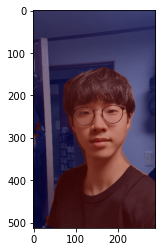

In [10]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

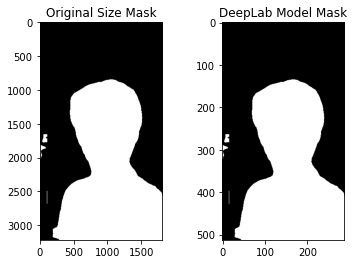

In [11]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

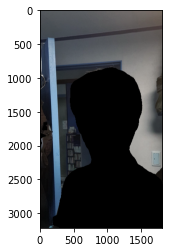

In [12]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

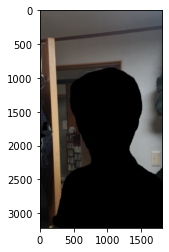

In [13]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

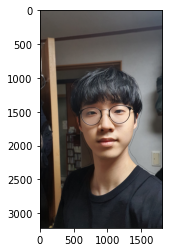

In [14]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
# 이미지 저장
cv2.imwrite(os.path.join(img_path, "my_image_blur.jpg"), img_concat)

False

## 고양이 이미지

In [16]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(875, 640, 3) (513, 375, 3) 8


고양이 이미지는 seg_map.max()가 8인데 제대로 인식하였습니다.

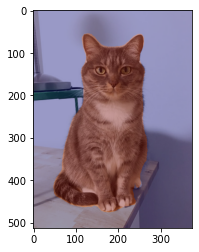

In [17]:
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0)
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

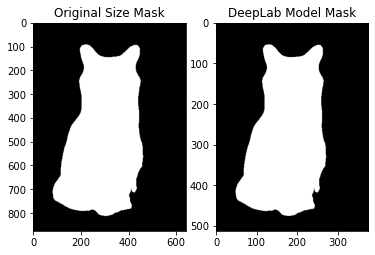

In [18]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

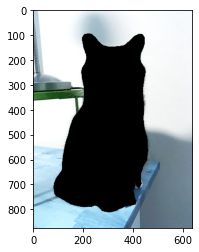

In [19]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)
plt.imshow(cat_img_bg)
plt.show()

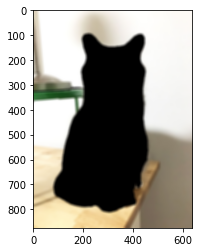

In [20]:
cat_img_bg_blur = cv2.blur(cat_img_bg, (13,13))
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

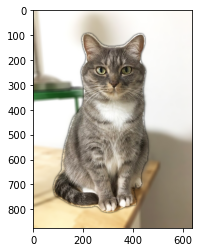

In [21]:
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 크로마키 배경 합성

현재 저의 이미지 속의 배경은 바닷가인데 뉴욕의 배경으로 바꿔보겠습니다.

In [22]:
img_resized_2, seg_map_2 = MODEL.run(img_orig_2)
print (img_orig_2.shape, img_resized_2.shape, seg_map_2.max())

(1440, 1440, 3) (513, 513, 3) 15


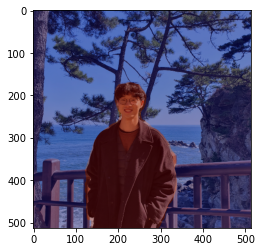

In [23]:
img_show_2 = img_resized_2.copy()
seg_map_2 = np.where(seg_map_2 == 15, 15, 0) # 예측 중 사람만 추출
img_mask_2 = seg_map_2 * (255/seg_map_2.max()) # 255 normalization
img_mask_2 = img_mask_2.astype(np.uint8)
color_mask_2 = cv2.applyColorMap(img_mask_2, cv2.COLORMAP_JET)
img_show_2 = cv2.addWeighted(img_show_2, 0.6, color_mask_2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))
plt.show()

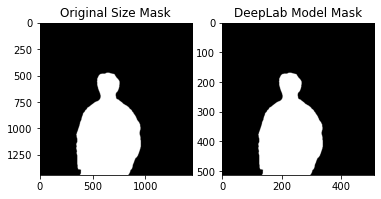

In [24]:
img_mask_up_2 = cv2.resize(img_mask_2, img_orig_2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_2 = cv2.threshold(img_mask_up_2, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

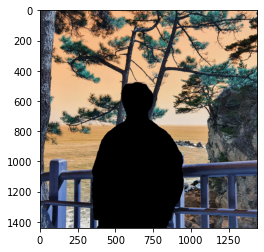

In [25]:
img_mask_color_2 = cv2.cvtColor(img_mask_up_2, cv2.COLOR_GRAY2BGR)
img_bg_mask_2 = cv2.bitwise_not(img_mask_color_2)
img_bg_2 = cv2.bitwise_and(img_orig_2, img_bg_mask_2)
plt.imshow(img_bg_2)
plt.show()

In [26]:
# 크로마키 배경 사이즈 변경
background_resized = cv2.resize(
    background_img_orig, (img_orig_2.shape[1], img_orig_2.shape[0]))

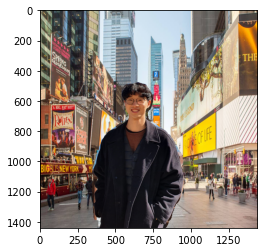

In [27]:
img_concat_2 = np.where(img_mask_color_2==255, img_orig_2, background_resized)
plt.imshow(cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB))
plt.show()

뉴욕에 도착했습니다~!

## 결과

Text(0.5, 1.0, 'Background person')

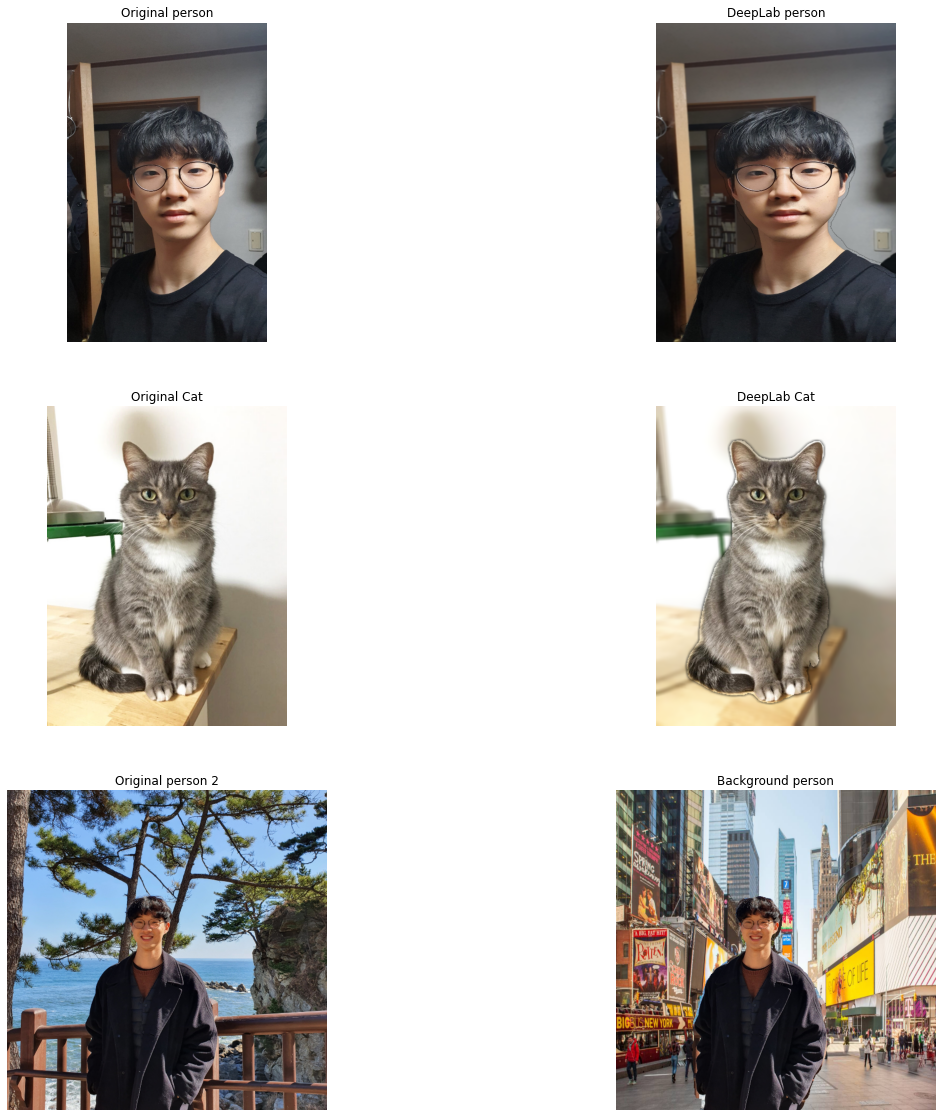

In [28]:
plt.figure(figsize=(20,20))

ax = plt.subplot(3,2,1)
plt.axis('off')
image_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(image_rgb, (500, 800))
plt.imshow(img_resized)
ax.set_title('Original person')

ax = plt.subplot(3,2,2)
plt.axis('off')
img_deeplab = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
img_deeplab_resized = cv2.resize(img_deeplab, (600,800))
plt.imshow(img_deeplab_resized)
ax.set_title('DeepLab person')


ax = plt.subplot(3,2,3)
plt.axis('off')
cat_image_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
cat_img_resized = cv2.resize(cat_image_rgb, (600, 800))
plt.imshow(cat_img_resized)
ax.set_title('Original Cat')

ax = plt.subplot(3,2,4)
plt.axis('off')
cat_deeplab = cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB)
cat_deeplab_resized = cv2.resize(cat_deeplab, (600,800))
plt.imshow(cat_deeplab_resized)
ax.set_title('DeepLab Cat')
                         
ax = plt.subplot(3,2,5)
plt.axis('off')
image_rgb_2 = cv2.cvtColor(img_orig_2, cv2.COLOR_BGR2RGB)
img_resized_2 = cv2.resize(image_rgb_2, (600, 600))
plt.imshow(img_resized_2)
ax.set_title('Original person 2')

ax = plt.subplot(3,2,6)
plt.axis('off')
background_img = cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB)
background_img_resized = cv2.resize(background_img, (600, 600))
plt.imshow(background_img_resized)
ax.set_title('Background person')

## 문제점

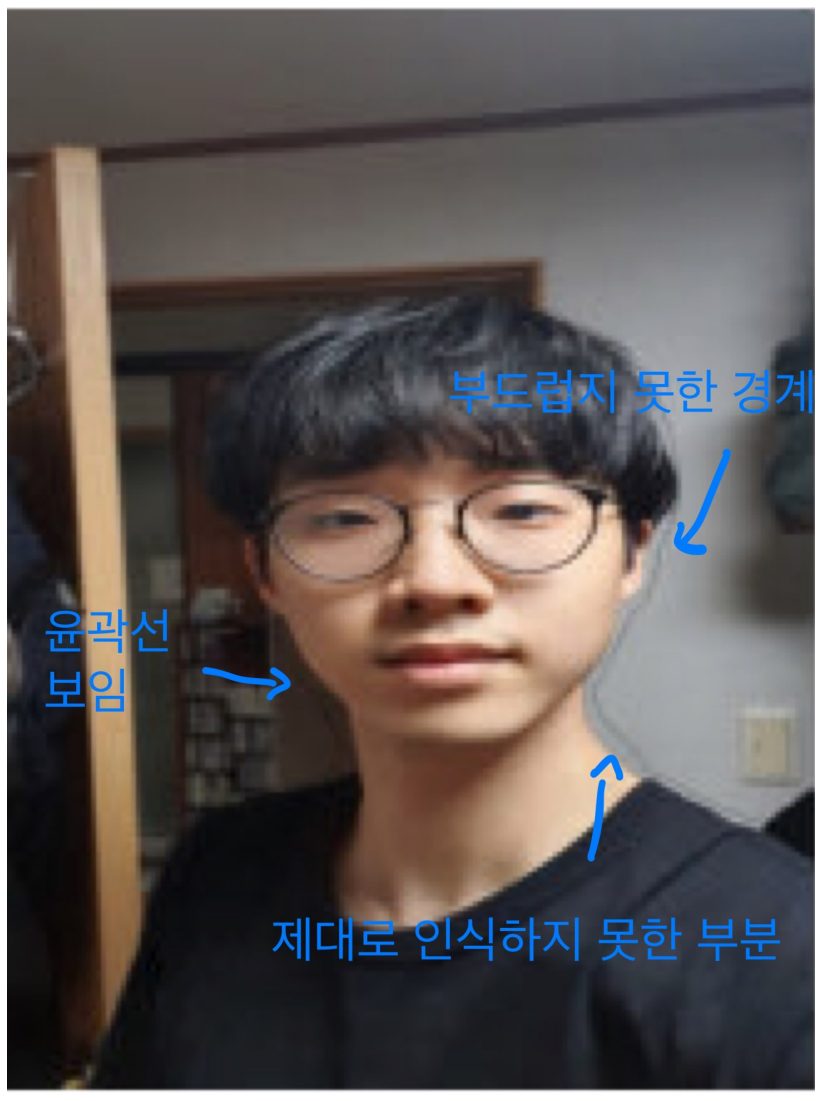

In [37]:
blur_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_blur.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
blur_img_orig = cv2.imread(blur_img_path) 

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(blur_img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

- object 주변으로 경계선이 그려지는데 굉장히 부자연스러워보입니다. 
- blur 부분과 그렇지 않은 부분이 나뉠때 부드럽지 않게 경계선이 그려집니다.
- blur 처리를 할 때 제대로 인식하지 못하는 부분이 보입니다.

## 문제 해결 방법

- 경계선을 없애기 위한 방법으로는 mask를 여러장 만들고 pixel을 조금씩 옮겨주어 concat하는 것입니다. 현재의 mask를 기준으로 왼쪽, 오른쪽, 위쪽으로 pixel을 이동시키고 블러 처리된 배경을 합성시키면 경계선이 이전보다 줄어들 것입니다.
- object를 따라 경계선이 부드럽지 그려지지 않는 문제와 제대로 인식하지 못한 부분은 세그멘테이션의 한계로 발생한 문제입니다. 사진의 심도를 더 표현할 수 있다면 세그멘테이션 효과를 높일 수 있을 것입니다. 현재는 한 개의 카메라로 촬영한 사진인데, 두 개의 카메라를 이용하면 사진의 심도를 계산하기에 용이해지고 object 경계를 지금보다 더 잘 표현할 수 있을 것으로 예상됩니다.

## 회고

- 심도를 표현하면서 부정확한 이미지 세그멘테이션의 한계가 존재해서 완벽하진 않지만 프로젝트의 이미지 세그멘테이션은 충분한 수준으로 이미지를 구분할 수 있는 기술인 것 같다.
- 이미지 세그멘테이션으로 자율주행, 암 감지, 위성 이미지 분석 등 다양한 분야에 사용되는데 실제 문제에서 어떻게 적용될지 궁금해서 다양한 모델을 찾아보고 싶은 마음이 들었다.